<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/CNN_LSTM_(test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's implement a CNN-LSTM hybrid model for Active Noise Control (ANC). The CNN extracts features from small segments of the audio, while the LSTM captures temporal dependencies across these segments, which is important for predicting an output signal that can create destructive interference when combined with the input.

### Code Implementation in Google Colab
The following code includes data loading, preprocessing, model definition, training, and visualization. It can be run directly in a Colab notebook.

### Explanation of the Updated Hybrid Model
1. **Model Architecture**:
   - The CNN layers extract features from short time windows of the audio waveform.
   - The LSTM layer captures temporal relationships between these features, allowing the model to consider long-term dependencies and time-varying noise patterns.
   - A fully connected layer maps the output of the LSTM back to a time-series signal.

2. **Training**:
   - The model is trained using Mean Squared Error (MSE) loss between the predicted waveform and the ideal inverted waveform.
   - The input is normalized, and the training runs for 20 epochs, which can be adjusted for better convergence.

3. **Prediction and Combination**:
   - After training, the model predicts the anti-sound waveform, which is then combined with the input waveform for destructive interference.
   - Visual plots help analyze the input, predicted, and combined waveforms.

4. **Audio Playback**:
   - You can listen to the input waveform, the predicted anti-sound waveform, and the combined result to evaluate the noise cancellation performance.

### Potential Next Steps
- Experiment with different architectures or deeper CNN and LSTM layers for improved accuracy.
- Tune hyperparameters like learning rate, hidden size, and number of epochs.
- Test the model with different types of noise to ensure robustness.

This hybrid model approach should be better suited for ANC tasks, as it combines the spatial feature extraction capabilities of CNNs with the temporal dependency modeling strengths of LSTMs.

In [ ]:
# Install necessary libraries
#!pip install torchaudio librosa matplotlib

# Import libraries
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from google.colab import files
from IPython.display import Audio

# Set up GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Step 1: Load the input audio file
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]
waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.to(device)

# Step 2: Preprocessing - Resample if needed and normalize
#resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
#waveform = resampler(waveform)
#sample_rate = 16000  # Using 16kHz for consistency


Using device: cpu


Saving 1-19872-B-36.wav to 1-19872-B-36 (1).wav


Sample rate of the input audio: 44100 Hz
Epoch 1/30 | Loss: 1.003131
Epoch 2/30 | Loss: 0.991257
Epoch 3/30 | Loss: 0.979674
Epoch 4/30 | Loss: 0.963655
Epoch 5/30 | Loss: 0.938877
Epoch 6/30 | Loss: 0.900462
Epoch 7/30 | Loss: 0.842234
Epoch 8/30 | Loss: 0.756554
Epoch 9/30 | Loss: 0.636969
Epoch 10/30 | Loss: 0.489929
Epoch 11/30 | Loss: 0.373551
Epoch 12/30 | Loss: 0.404746
Epoch 13/30 | Loss: 0.440155
Epoch 14/30 | Loss: 0.376707
Epoch 15/30 | Loss: 0.292870
Epoch 16/30 | Loss: 0.246340
Epoch 17/30 | Loss: 0.232937
Epoch 18/30 | Loss: 0.229560
Epoch 19/30 | Loss: 0.221184
Epoch 20/30 | Loss: 0.202738
Epoch 21/30 | Loss: 0.175303
Epoch 22/30 | Loss: 0.143714
Epoch 23/30 | Loss: 0.115065
Epoch 24/30 | Loss: 0.097038
Epoch 25/30 | Loss: 0.093988
Epoch 26/30 | Loss: 0.098899
Epoch 27/30 | Loss: 0.094908
Epoch 28/30 | Loss: 0.080173
Epoch 29/30 | Loss: 0.072785
Epoch 30/30 | Loss: 0.081646


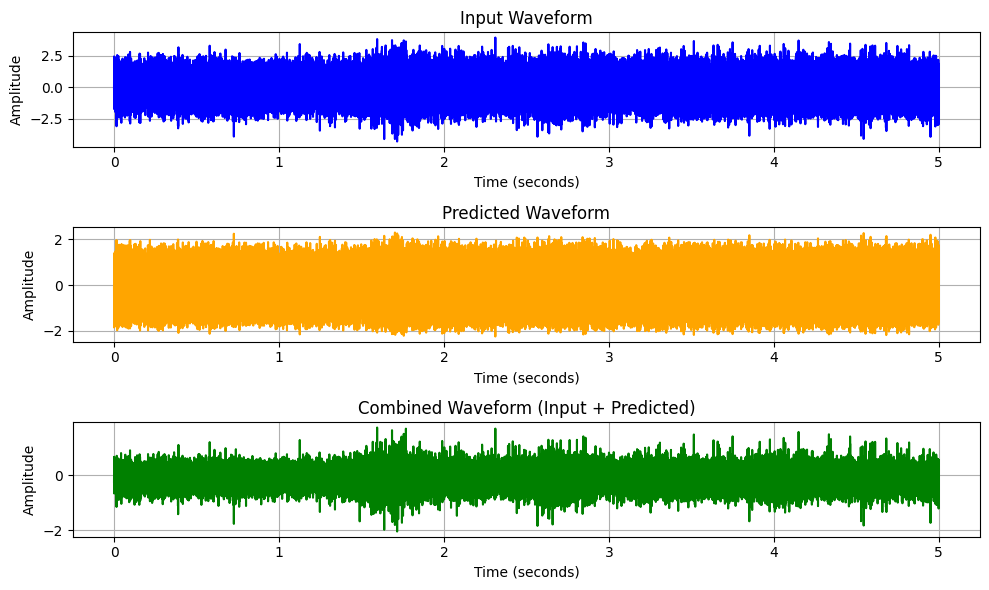

Playing original input waveform:


Playing predicted anti-sound waveform:


Playing combined waveform:


In [ ]:
# Step 2: Preprocessing - Normalize the waveform
waveform = (waveform - waveform.mean()) / waveform.std()

# Print the sample rate for reference
print(f'Sample rate of the input audio: {sample_rate} Hz')

# Step 3: Define a CNN-LSTM hybrid model for waveform-to-waveform regression
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CNN_LSTM, self).__init__()

        # CNN layers for feature extraction
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()

        # LSTM layer for temporal modeling
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected layer to map LSTM outputs to waveform predictions
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # CNN feature extraction
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Reshape for LSTM (batch_size, sequence_length, feature_size)
        x = x.permute(0, 2, 1)  # Switch to (batch, time, feature)

        # LSTM for temporal modeling
        lstm_out, _ = self.lstm(x)

        # Map LSTM output to predicted waveform
        out = self.fc(lstm_out)

        # Reshape back to (batch_size, 1, time)
        return out.permute(0, 2, 1)

# Initialize the model, loss function, and optimizer
input_size = 1  # Since we are predicting a 1D time series
hidden_size = 128
num_layers = 2
model = CNN_LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Reshape waveform for the model (batch_size, channels, samples)
waveform = waveform.view(1, 1, -1)  # Batch size = 1, Channels = 1, Samples = length of the waveform

# Step 4: Training the model
def train_model(model, waveform, epochs=30, verbose=True):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Predict inverted waveform
        output = model(waveform)
        inverted_waveform = -waveform  # Ideal target is the inverted input

        # Calculate loss
        loss = criterion(output, inverted_waveform)
        loss.backward()
        optimizer.step()

        # Print loss and other details if verbose is enabled
        if verbose:
            print(
                f'Epoch {epoch+1}/{epochs} | '
                f'Loss: {loss.item():.6f}'
            )

    return model



# Train the model
trained_model = train_model(model, waveform)

# Step 5: Predict the anti-sound using the trained model
model.eval()
with torch.no_grad():
    predicted_waveform = trained_model(waveform).squeeze().cpu().numpy()

# Step 6: Combine the input and predicted waveforms for destructive interference
combined_waveform = waveform.squeeze().cpu().numpy() + predicted_waveform

def plot_waveforms(waveform, predicted_waveform, sample_rate):
    # Create a time axis for the plots based on the sample rate
    time_axis = np.arange(waveform.shape[-1]) / sample_rate

    # Plot input waveform
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time_axis, waveform.squeeze().cpu().numpy(), label='Input Waveform', color='blue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Input Waveform')
    plt.grid(True)

    # Plot predicted waveform
    plt.subplot(3, 1, 2)
    plt.plot(time_axis, predicted_waveform.squeeze(), label='Predicted Waveform', color='orange')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Predicted Waveform')
    plt.grid(True)

    # Combine input and predicted waveform to visualize cancellation
    combined_waveform = waveform.squeeze().cpu().numpy() + predicted_waveform.squeeze()
    plt.subplot(3, 1, 3)
    plt.plot(time_axis, combined_waveform, label='Combined Waveform', color='green')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Combined Waveform (Input + Predicted)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example call to the plotting function after predictions:
plot_waveforms(waveform, predicted_waveform, sample_rate)

# Step 8: Audio Playback
print("Playing original input waveform:")
display(Audio(waveform.squeeze().cpu().numpy(), rate=sample_rate))

print("Playing predicted anti-sound waveform:")
display(Audio(predicted_waveform, rate=sample_rate))

print("Playing combined waveform:")
display(Audio(combined_waveform, rate=sample_rate))
